# Tutorial 4 - Testing

In this tutorial we are going to see if our model works when reloaded and how it can be actually re-used to working with real world data. At this point we are prepareing a conditional function that will be put into deployment and available for other to be re-used. It needs to be emphasized: we have not created a model for deployment just yet. We only prepared the skeleton of what can be used for pratical applications.

First, let's load the model again and use in the production.

In [1]:
# We need to get back our model in production, so load the needed packages
import torch                              
import torch.nn as nn                     
import torch.nn.functional as F              
import torch.optim as optim                  
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Remember to load our device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# And get our model
class Network(nn.Module):
    def __init__(self):                                             
        super(Network, self).__init__()                             
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                                   out_channels = 16,
                                   kernel_size = 5,
                                   stride = 1,
                                   padding = 2),                        
            nn.ReLU(),                                                
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)                                    
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16,
                                   out_channels = 32,
                                   kernel_size = 5,
                                   stride = 1,
                                   padding = 2),                        
            nn.ReLU(),                                                
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)                                    
            )
        
        self.fc1 = nn.Linear(in_features = 7*7*32,                  
                             out_features = 10)                    
    
    # A method for putting information through the network
    # t - is a tensor of information essentially
    def forward(self, t):
        out = self.conv1(t)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out
    
# And prepare it
model = Network().to(device)

In [4]:
# It seems to load quite fine
model

Network(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

In [5]:
# Now there are couple of conditions we used to work with, so let's bring them back
BATCH = 16

# And let's load the data we used to work with, to see if we can replicate our models performance
mnist_testing = datasets.MNIST(root = "../Tutorial 3 - Model/data",
                               train = False,               
                               transform = transforms.ToTensor()) 

# And return our data loader
data_loader = torch.utils.data.DataLoader(dataset = mnist_testing,
                                          batch_size = BATCH,
                                          shuffle = False)

In [6]:
# And let's prepare now in a function an ability of a network to process our information and predicti on it
def make_prediction(model, data_loader):
    """Make predictions with the model of your choice and data you want to use."""
    model.eval()

    with torch.no_grad(): 
        correct = 0      
        total = 0     

        # Now go through the testing set
        for images, labels in data_loader:
            images = images.to(device) 
            labels = labels.to(device) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

In [7]:
# Now make predictions
make_prediction(model = model,
                data_loader = data_loader)

Test Accuracy of the model on the 10000 test images: 13.72 %


The prediction seems horrible. What happened? It almost feels as though it would be random, where th network guesses what is depicted in an image 1 time out of 10...

Well, that's because it is. We have not loaded the weight back into the newly created model, so what we are working essentially - is a completelly random weights based generated model, that is not accurate in it's work at all. This was done on purpose to demonstrate what would be the performance of a network if it did not have it's previous learned weight loaded. So let's load the weights and try this again.

In [8]:
# Let's load everything from scratch
model_trained = Network().to(device)
model_trained.load_state_dict(torch.load("../Tutorial 3 - Model/model.ckpt"))
make_prediction(model = model_trained,
                data_loader = data_loader)

Test Accuracy of the model on the 10000 test images: 99.05 %


Hey! Seems we managed to replicate the results from our tutorial 3. That's great! This is an indication that our model now works.

But...so what? 
The only things we can work with currently is the MNIST data. Doesn't make it that exciting. What if we want to feed it our own data...then what? Well. This is what we should prepare currently.

Let's get several images from online of different numbers from 0 to 9. Images are saved into a folder called `numbers`. The only condition that was followed: the number should be darker in the image than the background and only it should be present. Otherwsie - the files are named randomly, and even of different formats. Take a look yourself (all downloaded from google at random): 

In [9]:
import os
from os import walk
from os.path import join

In [10]:
# See the file names
files = []
for (dirpath, dirnames, filenames) in walk("numbers"):
    files.extend(filenames)
    
files

['4qwe.png',
 '551311889.jpg',
 '9asd.png',
 'download.png',
 'download_1.png',
 'images.png',
 'number-1_1.jpg',
 'sddasda.png',
 'Video_8_Logo.svg.png',
 'zzzz.png']

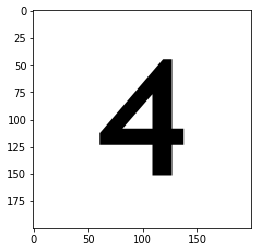

In [13]:
img = mpimg.imread('numbers/4qwe.png')
imgplot = plt.imshow(img)

numbers/4qwe.png


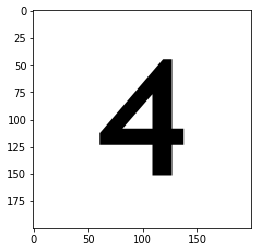

numbers/551311889.jpg


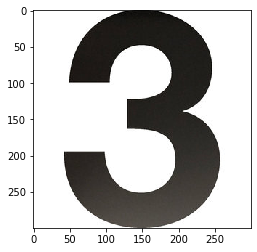

numbers/9asd.png


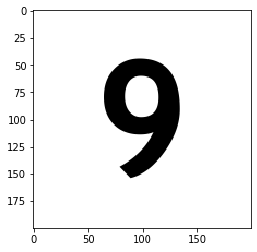

numbers/download.png


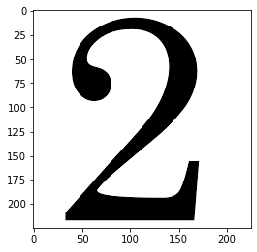

numbers/download_1.png


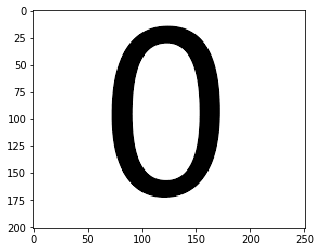

numbers/images.png


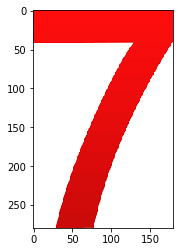

numbers/number-1_1.jpg


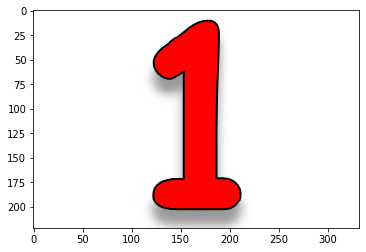

numbers/sddasda.png


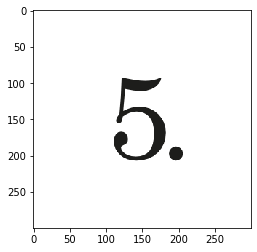

numbers/Video_8_Logo.svg.png


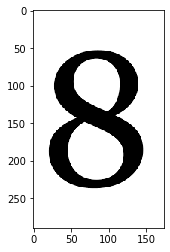

numbers/zzzz.png


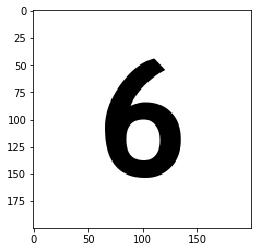

In [14]:
# Visualize them
for file in files:
    print(join("numbers/", file))
    plt.imshow(mpimg.imread(join("numbers/", file)))
    plt.show()

But you can notice that there is a problem - they are all of different sizes and not even in the formating we want them to be. The numbers are darker than the background, though in reality, we worked with a different set. So here we will have to create few functions to accomodate us with that, as in the real world pictures also might be fo different sizes and shapes. And we will assume that people write with dark inks on light surface than the other way arround.

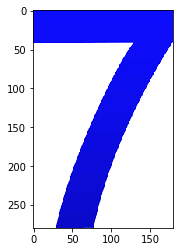

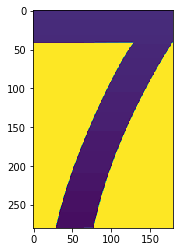

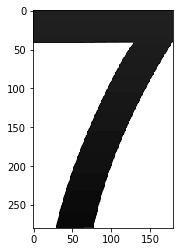

In [15]:
# We will get that help from opencv package
import cv2

img_0 = cv2.imread("numbers/images.png")
plt.imshow(img_0)
plt.show()

img = cv2.imread("numbers/images.png", 0) # Read the image as grayscale
plt.imshow(img)
plt.show()
plt.imshow(img, cmap = "gray")
plt.show()

# You can see that the image was converted to be grayscale. Something we want.

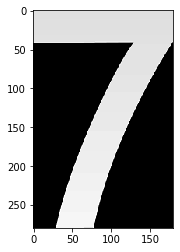

In [16]:
# Now let's invert the colors
img_inv = cv2.bitwise_not(img)
plt.imshow(img_inv, cmap = "gray")
plt.show()
# So we get roughlt what we need and used to work with

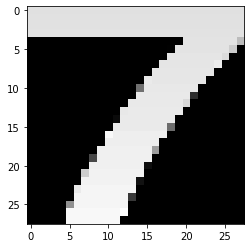

In [17]:
# Now let's care about getting the image and resizing it
img_inv_res = cv2.resize(img_inv, (28, 28))
plt.imshow(img_inv_res, cmap = "gray")
plt.show()

The image looks...scary. But it's what we need to feed to our network. Therefore, what we now need, is a function that preprocesses images into the form that we can work with. 

In [18]:
def images_preprocess(path):
    """An image is preprocessed and returned in a form that the NN model understands."""
    import cv2
    img = cv2.imread(path, 0)                      # Get an image
    img_inv = cv2.bitwise_not(img)                 # Invert an image
    img_inv_res = cv2.resize(img_inv, (28, 28))    # Resize an image
    img_inv_res_tensor = torch.tensor(img_inv_res) # Move data to Torch Tensor
    return img_inv_res_tensor

Now we can build our images accumulator that will further be passed to the model for predictions making.

In [19]:
storage = "numbers/"  # Folder that stores all of our number values
images = []           # What will we everntually have in order to pass to our model

files = []
for (dirpath, dirnames, filenames) in walk(storage):
    files.extend(filenames)

for file in files:
    image = images_preprocess(join(storage, file))
    images.append(image)

In [20]:
# Update how our data_loader functions as now we will be processing different information
loader_images = torch.utils.data.DataLoader(dataset = images,
                                            batch_size = 16,
                                            shuffle = False)

We do have to re-make our predictions function, as now we are not operating with known labels anymore.

In [21]:
# And let's prepare now in a function an ability of a network to process our information and predicti on it
def prediction(model, data_loader):
    """Make predictions with the model of your choice and data you want to use."""
    model.eval()

    with torch.no_grad():  

        # Predict one by one
        for images in data_loader:
            images = images.reshape(-1, 1, 28, 28).to(device, dtype=torch.float) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print("I believe this is the following image: {}".format(predicted))
            
        return predicted.cpu().numpy()

In [22]:
#Let's try to make predictions
predicted = prediction(model = model_trained,
                       data_loader = loader_images)

I believe this is the following image: tensor([4, 3, 9, 1, 0, 1, 1, 5, 8, 6])


These are the results we get. The sequence has not been changed. Hence we can check which were predicted how. In total, with given numbers, our model recognized 8/10 values (if I did not miss something). Now that we have a partially working system, what can also be done - is to make our system rename the files to what it sees in them, which makes sense from practical perspective as previously we had a disorganized list. A copy of the folder is created and it will be updated sequentially. Since the sequence does not break in python, we can rely on using the os walk again.

In [23]:
# Rename the files while walking through them
counter = 0
for (dirpath, dirnames, filenames) in walk("numbers_copy"):
    for file in filenames:
        os.rename("numbers_copy/" + str(filenames[counter]), "numbers_copy/" + "entry" + str(counter) + "_" + str(predicted[counter]) + ".png")
        counter += 1

Now that renaming is done and successful - we can focus on packing everything into a one type executable function, that will allow the users to easily work arround with these files are later we will package everything into a deployable environemnt.